# Keras (Tensorflow Backend) を利用してMNISTの分類を行う

## 概要

このノートブックでは、Amazon SageMaker上でKerasを実行し、MNISTの手書き数字の分類を学習します。Kerasを動作させるpythonのファイルとして、以下の2種類を`./src`に保存しています。

- [keras_mlp_mnist.py](./src/keras_mlp_mnist.py)  
Kerasで簡単なMLPを構築したものです。
- [keras_cnn_mnist.py](./src/keras_cnn_mnist.py)  
KerasのMNIST用の[CNN](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)をベースに作成しています。


## データセットのS3へのアップロード

- keras.datasetsを利用してmnistのデータをダウンロードしてnpz形式で保存します。
- 保存したnpz形式のファイルを、SageMaker Python SDKを利用してS3にアップロードします。

In [1]:
import os
import keras
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/train', image=x_train, label=y_train)
np.savez('./data/test', image=x_test, label=y_test)

import sagemaker
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
input_data = sagemaker_session.upload_data(path='./data', bucket=bucket_name, key_prefix='dataset/mnist')
print('Training data is uploaded to: {}'.format(input_data))

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-314676777416


Training data is uploaded to: s3://sagemaker-us-east-1-314676777416/dataset/mnist


## コードの変更箇所

kerasのMNIST用の[CNN](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)とSageMaker用のコード[keras_cnn_mnist.py](./src/keras_cnn_mnist.py)の違いを紹介します。SageMaker用のコードでは以下の4点が異なります。


**1. 以下のmain guardの中に、学習してモデルを保存するまでのコードを書くようにします。**

```python
    if __name__ == '__main__':
```

**2. Main guardの最初には、APIから渡される引数やS3上の学習データの位置、モデルの保存場所を受け取るコードを書きます。**

```python
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=100)
    parser.add_argument('--n-class', type=int, default=10)
    ...
    
    args, _ = parser.parse_known_args()
```
**3. 学習完了後、KerasのモデルでなくTensorflow Servingでデプロイ可能なモデルとして保存します。**

Tensorflow Serving で利用できるようにモデルを保存します。

```python
    sess = K.get_session()
    tf.saved_model.simple_save(
        sess,
        os.path.join(args.model_dir, 'model/1'),
        inputs={'inputs': model.input},
        outputs={t.name: t for t in model.outputs})
```


## SageMakerでの学習

Tensorflowをバックエンドとして学習するため、TensorflowのEstimatorを呼び出します。利用するpythonのコードは、`keras_mlp_mnist.py`と`keras_cnn_mnist.py`のどちらでも可能です。MLPのほうが短時間で学習が終わります。

In [2]:
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

role = get_execution_role()
mnist_estimator = TensorFlow(entry_point = "./src/keras_mlp_mnist.py",
          role=role,
          train_instance_count=1,
          train_instance_type="ml.m4.xlarge",
          framework_version="1.11.0",
          py_version='py3',
          script_mode=True,
          hyperparameters={'batch-size': 64,
                         'n-class': 10,
                         'epochs': 2})

mnist_estimator.fit(input_data)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-314676777416
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2018-12-18-07-34-09-859


2018-12-18 07:34:10 Starting - Starting the training job...
2018-12-18 07:34:14 Starting - Launching requested ML instances.........
2018-12-18 07:35:43 Starting - Preparing the instances for training...
2018-12-18 07:36:36 Downloading - Downloading input data...
2018-12-18 07:36:54 Training - Downloading the training image
2018-12-18 07:36:59,965 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2018-12-18 07:36:59,973 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2018-12-18 07:37:00,293 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2018-12-18 07:37:00,307 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    

24768/60000 [===========>..................] - ETA: 19s - loss: 0.3120 - acc: 0.9034


43904/60000 [====================>.........] - ETA: 8s - loss: 0.2360 - acc: 0.9272



2018-12-18 07:37:27 Training - Training image download completed. Training in progress.44032/60000 [=====================>........] - ETA: 8s - loss: 0.2357 - acc: 0.9273
60000/60000 [==============================] - 34s 564us/step - loss: 0.2016 - acc: 0.9377 - val_loss: 0.0923 - val_acc: 0.9717
Epoch 2/2

   64/60000 [..............................] - ETA: 39s - loss: 0.0927 - acc: 0.9531


18176/60000 [========>.....................] - ETA: 23s - loss: 0.0815 - acc: 0.9739


36416/60000 [=================>............] - ETA: 13s - loss: 0.0775 - acc: 0.9758


54336/60000 [==========================>...] - ETA: 3s - loss: 0.0736 - acc: 0.9773


60000/60000 [==============================] - 34s 570us/step - loss: 0.0727 - acc: 0.9776 - val_loss: 0.0815 - val_acc: 0.9747
Test loss: 0.08154172416776419
Test accuracy: 0.9747
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
2018-12-18 07:38:12,211 sagemaker-containers INFO     Reporting training SUCCESS

2018-12-18 07:38:20 Uploading - Uploading generated training model
2018-12-18 07:38:20 Completed - Training job completed
Billable seconds: 104


## SageMakerでのデプロイ

推論を行うために学習したモデルをデプロイします。deploy() メソッドでは、デプロイ先エンドポイントのインスタンス数、インスタンスタイプを指定します。

In [5]:
predictor = mnist_estimator.deploy(instance_type='ml.m4.xlarge',
                                   initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2018-12-18-07-34-09-859
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2018-12-18-07-34-09-859


---------------------------------------------------------------!

デプロイが終わったら実際に手書き文字認識を行ってみましょう。ランダムに5枚選んで推論をしてみます。

The predicted labels are: [7 6 0 6 0]


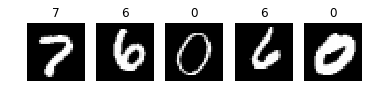

In [6]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_test.shape[0] - 1), num_samples)
images, labels = x_test[indices]/255, y_test[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

## エンドポイントの削除

In [7]:
 sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-scriptmode-2018-12-18-07-34-09-859
